In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.ref_book import ReferenceBookAnonymization

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
set_seed(42)

2024-06-13 16:58:46.344003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на анонимизированном с помощью справочников наборе данных i2b2 2014 без учёта регистра
    6. Version 5 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, GPT2 обучено на тренировочном наборе данных i2b2 2014 
    7. Version 6 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, GPT2 обучено на тренировочном наборе данных i2b2 2014 
    8. Version 7 --- обученная на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра

### Этап 1: Демонстрация результатов на наборе данных i2b2 2006
Демонстрация включает в себя измерение метрик Recall, Precision и $F_1$ score для следующий моделей:
* BERT-base-cased
* BERT-base-uncased
* BERT-large-cased
* BERT-large-uncased

#### BERT-base-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

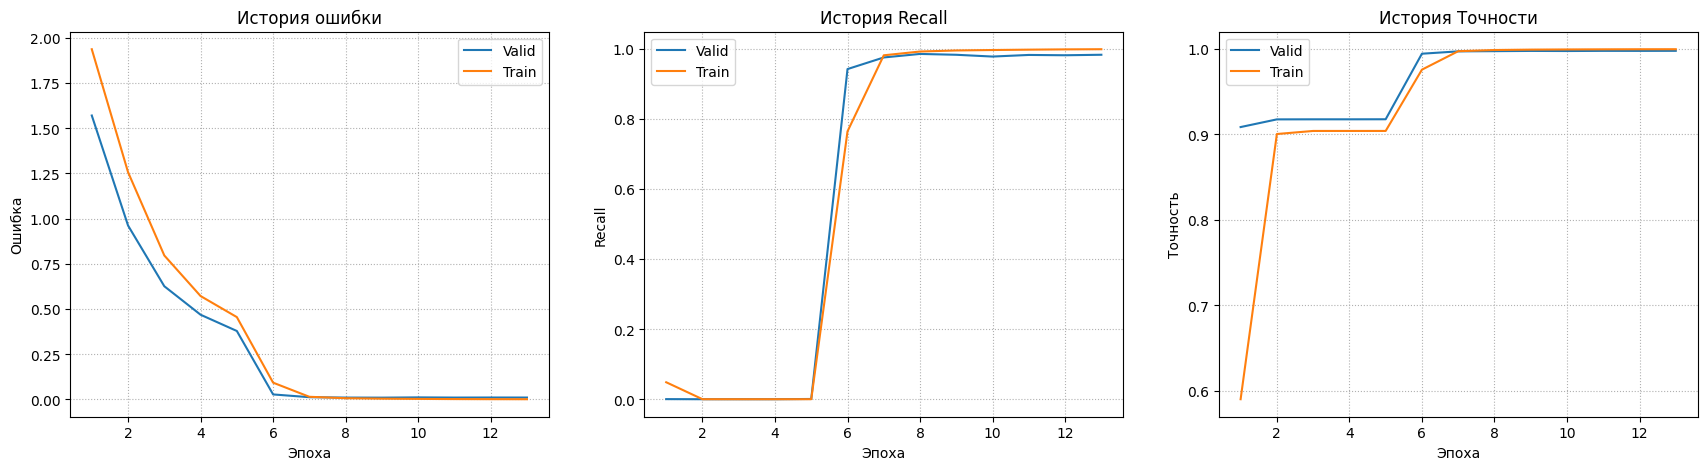

In [7]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(0)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [8]:
# Data processing
test_dataset = get_ner_dataset(dataset_type=i2b2_2006_data_config['dataset_type'],
                               path_to_folder=i2b2_2006_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer="bert-base-cased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(0)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

Uniting records: 100%|██████████| 220/220 [00:00<00:00, 892.26it/s]


              precision    recall  f1-score   support

        NAME     0.9841    0.9921    0.9881      8811
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.9599    0.9553    0.9576      4209
         AGE     0.0000    0.0000    0.0000         6
        DATE     0.9914    0.9925    0.9920      5224
          ID     0.9946    0.9989    0.9967      5679
     CONTACT     0.9930    0.9724    0.9826       435

   micro avg     0.9841    0.9868    0.9855     24364
   macro avg     0.7033    0.7016    0.7024     24364
weighted avg     0.9838    0.9868    0.9853     24364



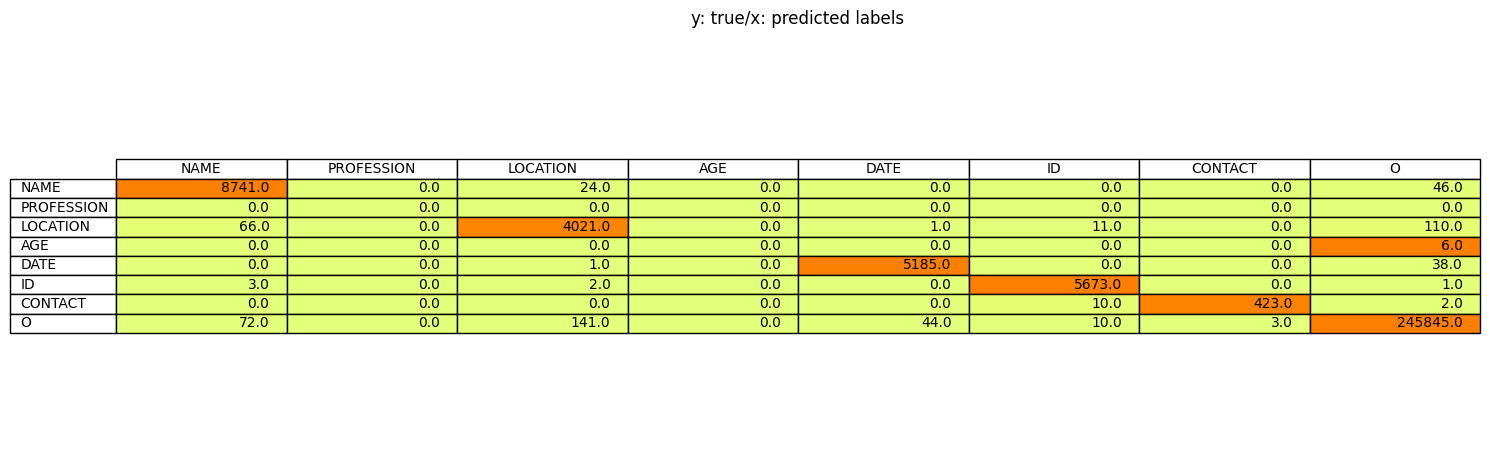

Wrongly predicted examples:
_____ Record 593 _____
| Sentence:    | 340169283 | FIH      | 7602710 94633 / 64ub 692217 | 3 / 28 | / 1994 12 : 00 : 00 AM PNEUMONIA Unsigned DIS Report Status : Unsigned ADMISSION DATE : | 03 - 28 | - 94 DISCHARGE DATE : | 03 - 31 | - 94 PRINCIPAL DIAGNOSIS : pneumonia ASSOCIATED DIAGNOSIS : 1. chronic obstructive pulmonary disease. 2. diabetes mellitus. 3. schizoaffective disorder. HISTORY OF PRESENT ILLNESS : The patient is a 56 year old homeless man who lives in a | Fayran Wara | . He has a history of diabetes, smoking, alcohol and chronic obstructive pulmonary disease who presents with three days of intermittently productive cough, fever, fatigue and malaise. This is his second | Fairm of Ijordcompmac Hospital | admission in the past four months for the same complaint. Staff at the | Ln, Ingloard | sent him to the emergency room on the | 25th | when they noted chills and fever to 103. 6. He presented to the emergency room slightly short of breath with

In [11]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-base-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

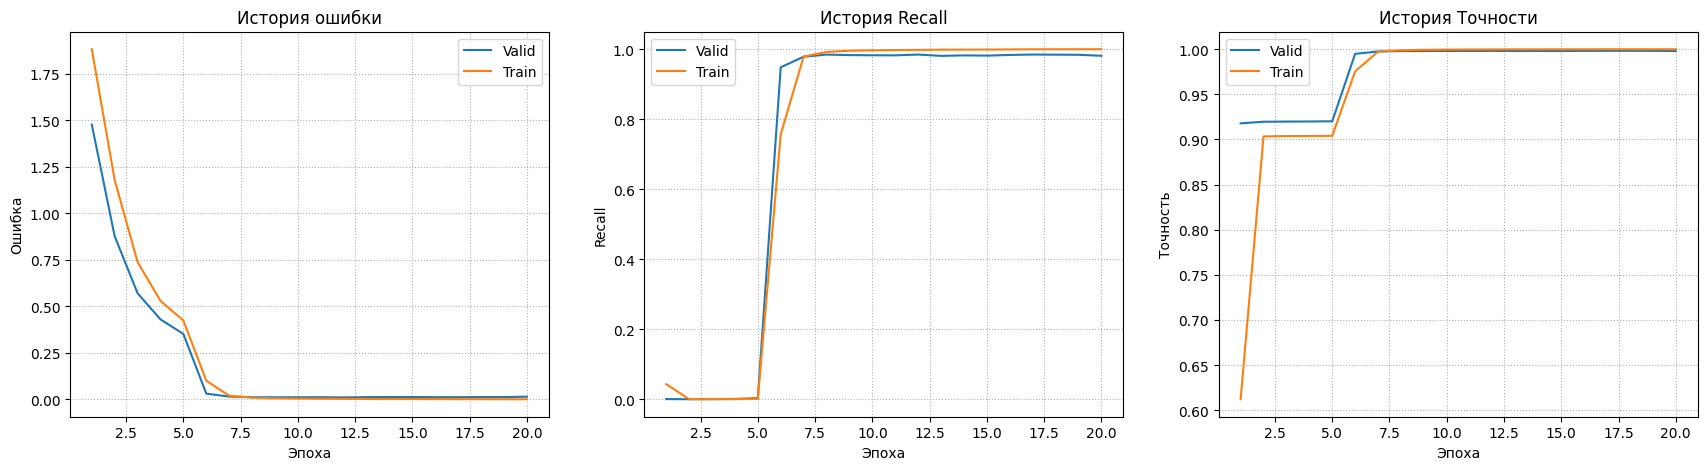

In [12]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(1)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [13]:
# Data processing
test_dataset = get_ner_dataset(dataset_type=i2b2_2006_data_config['dataset_type'],
                               path_to_folder=i2b2_2006_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-base-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [14]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(1)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

Uniting records: 100%|██████████| 220/220 [00:00<00:00, 1020.66it/s]


              precision    recall  f1-score   support

        NAME     0.9891    0.9891    0.9891      6610
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.9859    0.9533    0.9693      3664
         AGE     1.0000    0.5000    0.6667         6
        DATE     0.9965    0.9916    0.9941      5224
          ID     0.9952    0.9994    0.9973      5361
     CONTACT     0.9901    0.9829    0.9865       409

   micro avg     0.9920    0.9859    0.9889     21274
   macro avg     0.8510    0.7738    0.8004     21274
weighted avg     0.9919    0.9859    0.9888     21274



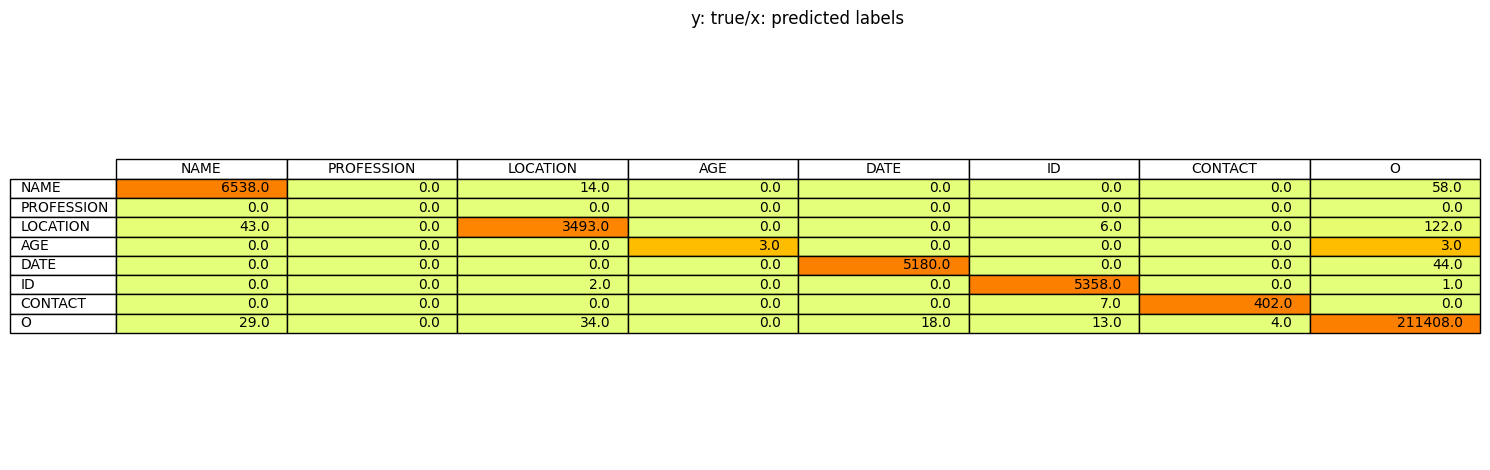

Wrongly predicted examples:
_____ Record 447 _____
| Sentence:    | 511446216 | rwh      | 1526625 883375 5586925 | 1 / 24 | / 2004 12 : 00 : 00 am ed discharge summary unsigned dis report status : unsigned ed discharge notification | in, so | mrn : | 1526625 | age : 49y registration date : | 01 / 24 | / 2004 06 : 34 pm preliminary report this is to notify you that your patient, | in, so | arrived in the emergency department at | ro woodma healthcare | on | 01 / 24 | / 2004 06 : 34 pm. the patient presented with a chief complaint of pre syncope. following evaluation and treatment, the patient's disposition at the end of the visit was admitted as an inpatient to | ro woodma healthcare | . the patient's preliminary admitting physician is | fongbain, na k | and the preliminary diagnosis is r / o mi. please note this information may have been updated on the inpatient unit. if you need additional information please call | 662 - 747 - 1199 | . pcp name : | kaysstongeuphbreunsterpkote, aje t 

In [16]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

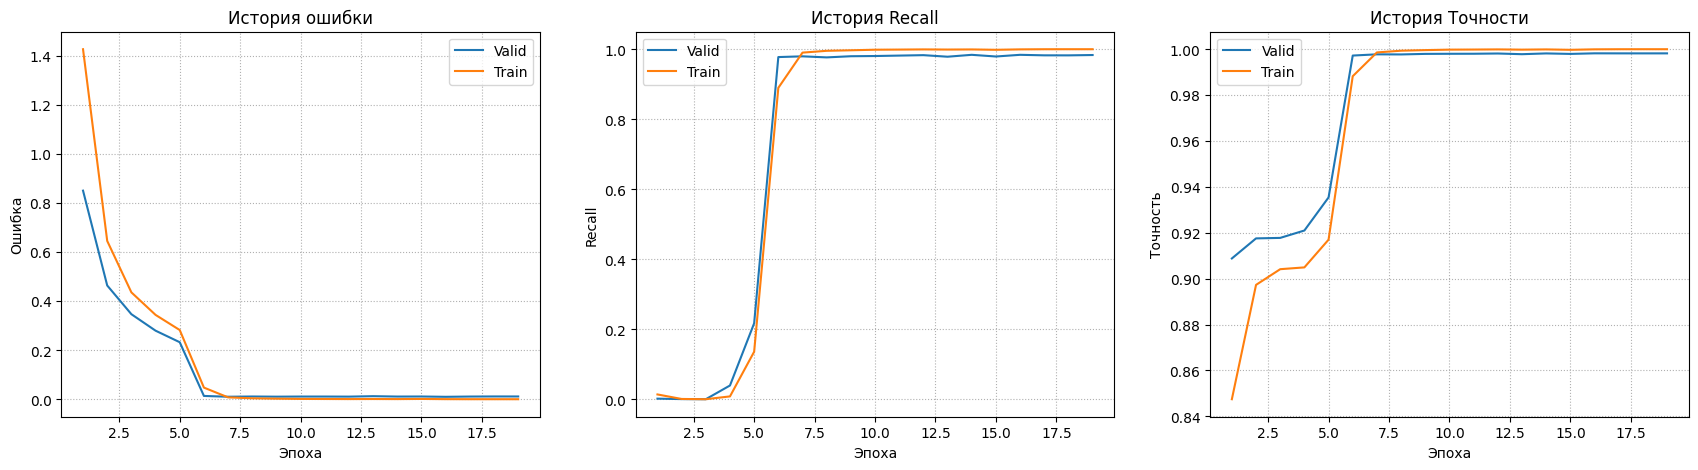

In [17]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(0)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [18]:
# Data processing
test_dataset = get_ner_dataset(dataset_type=i2b2_2006_data_config['dataset_type'],
                               path_to_folder=i2b2_2006_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer="bert-large-cased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


In [19]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(0)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [ ]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

Uniting records: 100%|██████████| 220/220 [00:00<00:00, 890.11it/s]


              precision    recall  f1-score   support

        NAME     0.9891    0.9911    0.9901      8811
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.9831    0.9425    0.9624      4209
         AGE     1.0000    0.3333    0.5000         6
        DATE     0.9967    0.9958    0.9963      5224
          ID     0.9951    0.9981    0.9966      5679
     CONTACT     0.9977    0.9816    0.9896       435

   micro avg     0.9913    0.9850    0.9882     24364
   macro avg     0.8517    0.7489    0.7764     24364
weighted avg     0.9913    0.9850    0.9880     24364



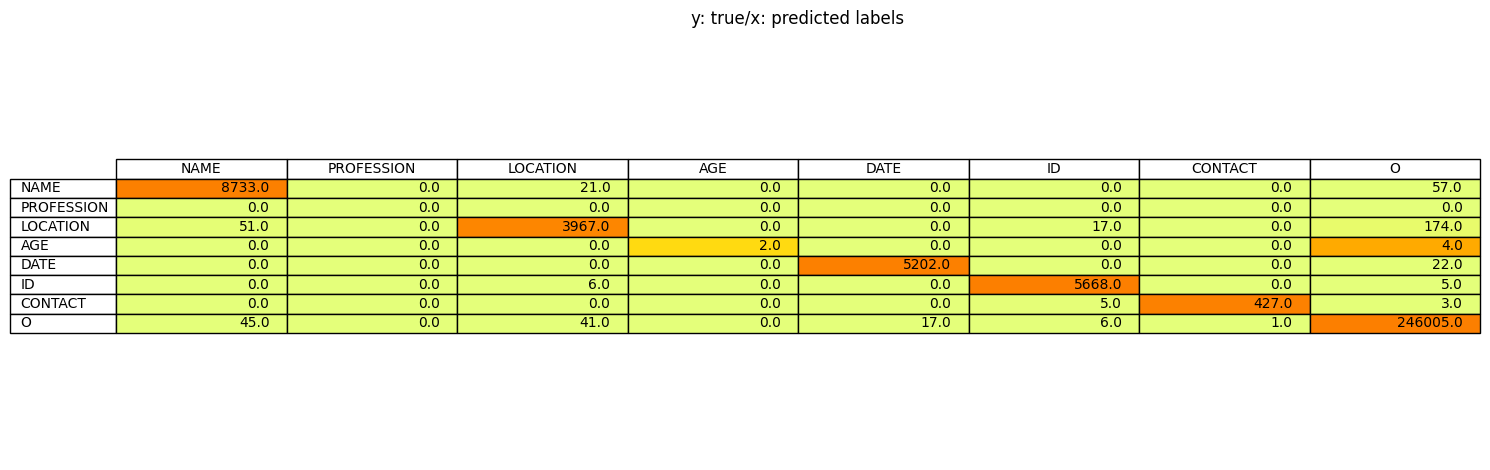

Wrongly predicted examples:
_____ Record 495 _____
| Sentence:    | 323414533 | ELMVH    | 53235330 700600 | 5 / 22 | / 2001 12 : 00 : 00 AM pp DIS Admission Date : | 05 / 22 | / 2001 Report Status : Discharge Date : | 05 / 24 | / 2001 * * * * * * DISCHARGE ORDERS * * * * * * | JESCTLANDSCHOELL, RICKILA | 712 - 58 - 43 - 6 Q59 | Room : | NCP0 - 370 | Service : OBS DISCHARGE PATIENT ON : | 05 / 24 | / 01 AT 12 : 00 PM CONTINGENT UPON Not Applicable WILL D / C ORDER BE USED AS THE D / C SUMMARY : YES DISPOSITION : Home DISCHARGE MEDICATIONS : DIET : No Restrictions Activity - As tolerated FOLLOW UP APPOINTMENT ( S ) : | co hospital | 2 / 6wks, ALLERGY : G6pd deficiency ADMIT DIAGNOSIS : Spontaneous vaginal delivery PRINCIPAL DISCHARGE DIAGNOSIS ; Responsible After Study for Causing Admission ) pp OTHER DIAGNOSIS ; Conditions, Infections, Complications, affecting Treatment / Stay pp OPERATIONS AND PROCEDURES : Vaginal delivery : Spontaneous Placenta : Delivery : Spontaneous Condition : No

In [21]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

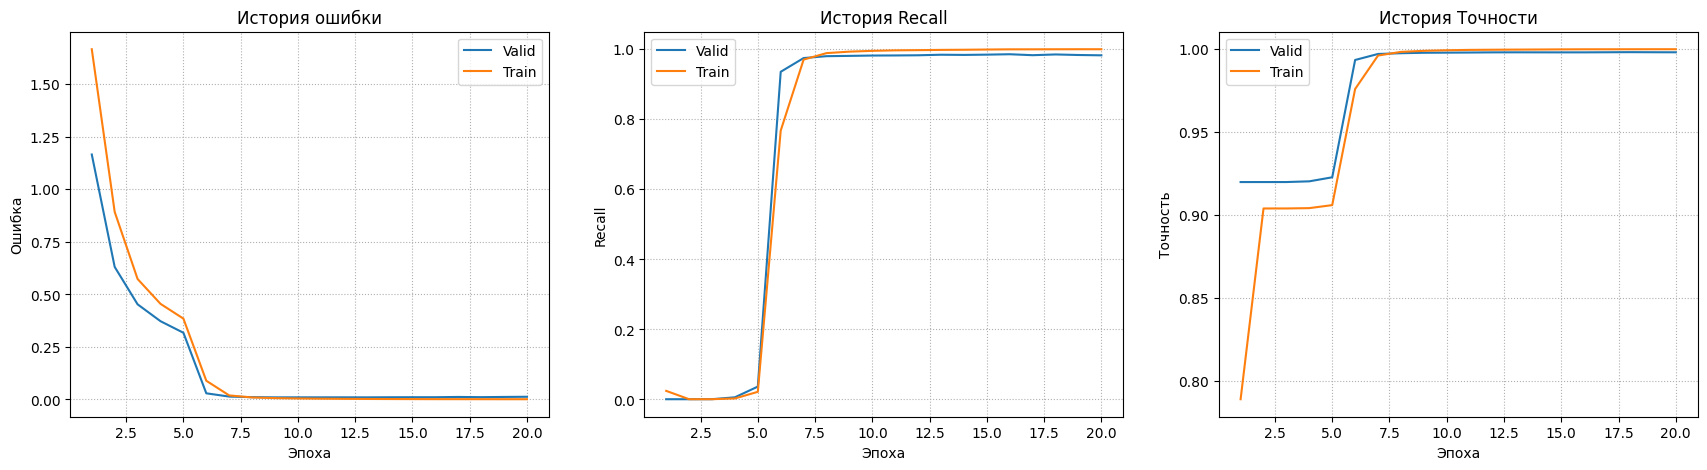

In [22]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(1)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [23]:
# Data processing
test_dataset = get_ner_dataset(dataset_type=i2b2_2006_data_config['dataset_type'],
                               path_to_folder=i2b2_2006_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2006_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(1)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [ ]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

Computing predictions:   0%|          | 0/121 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Uniting records: 100%|██████████| 220/220 [00:00<00:00, 759.95it/s]


              precision    recall  f1-score   support

        NAME     0.9903    0.9884    0.9893      6610
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.9760    0.9659    0.9709      3664
         AGE     0.0000    0.0000    0.0000         6
        DATE     0.9935    0.9952    0.9944      5224
          ID     0.9972    0.9981    0.9977      5361
     CONTACT     1.0000    0.9658    0.9826       409

   micro avg     0.9906    0.9879    0.9892     21274
   macro avg     0.7081    0.7019    0.7050     21274
weighted avg     0.9903    0.9879    0.9891     21274



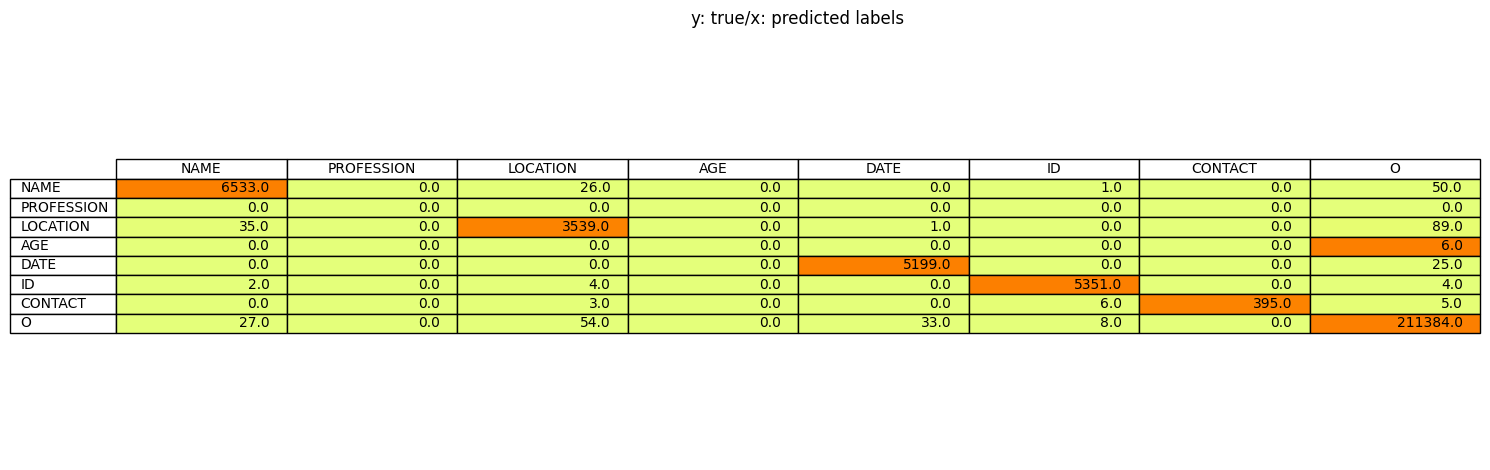

Wrongly predicted examples:
_____ Record 168 _____
| Sentence:    | 101407944 | pumc     | 3925529 441763 2345939 | 4 / 30 | / 2005 12 : 00 : 00 am discharge summary signed dis report status : signed discharge summary name : | caugh, di k | unit number : | 569 - 82 - 26 | admission date : | 04 / 30 | / 2005 discharge date : | 5 / 14 | / 05 | 05 / 14 | / 2005 principal diagnosis : right parietal occipital temporal tumor. principal procedure : | 5 / 5 | / 05 right parietal occipital craniotomy and debulking of tumor using stulz neuro navigation. history of present illness : the patient is a pleasant 83 - year - old retired psychiatrist who presents with a chief complaint of gait difficulty for the last five to six months. the patient has a history of laryngeal cancer in 2000 and 2001, cva in 2001 to 2002 and hypertension, who has a six month history of progressive difficulty in ambulation. the patient was in previously good health when he reports starting to notice problems ambulating ab

In [26]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

**Вывод:**  
Recall предсказания класса превышает $98\%$ для всех меток кроме 'AGE' в свзязи с его малым представлением в выборке (51 токен). Самый низкая точность распознования среди остальных, классов касается метки 'LOCATION'. При этом стоит отметить, что хотя класс 'CONTACT' в обучающей выборке представлен хуже 'LOCATION', из-за фиксированного формата его записи модель распознает данный класс успешннее.